# Import Libraries

In [1]:
import glob
import torch
import tables

import os,sys

import PIL
import numpy as np

import cv2
import matplotlib.pyplot as plt

from sklearn import model_selection

import sklearn.feature_extraction.image
import random

from typing import IO

seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the cross validation setup
random.seed(seed) # set the seed
print(f"random seed (note down for reproducibility): {seed} {sklearn.__version__}")

random seed (note down for reproducibility): 7310254255315717990 1.0.2


In [2]:
# uncomment if runnig on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task-1

# Change the path and the working directory 
path -> path to the ORCA dataset

working directory -> location to save the training,validation & test patches along with model weight dictionary.


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/cs424/validation_100'
wor_dir = "/content/drive/MyDrive/Colab Notebooks/cs424/"

# Data Preparation
patch extraction and storage in HDF5 format for training and validation dataset

In [11]:
dataname="assgn3"

patch_size=1000 #size of the tiles to extract and save in the database, must be >= to training size
stride_size=1000 #distance to skip between patches, 1 indicated pixel wise extraction, patch_size would result in non-overlapping tiles
mirror_pad_size=250 # number of pixels to pad *after* resize to image with by mirroring (edge's of patches tend not to be analyzed well, so padding allows them to appear more centered in the patch)
test_set_size=.1 # what percentage of the dataset should be used as a held out validation/testing set
patch_size_res = 224 #resize input images
classes=[0,1,2] #what classes we expect to have in the data, here we have only 2 classes but we could add additional classes and/or specify an index from which we would like to ignore



In [5]:
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates that images will be saved as unsigned int 8 bit, i.e., [0,255]
filenameAtom = tables.StringAtom(itemsize=2000) #create an atom to store the filename of the image, just incase we need it later, 

In [6]:
# files with shape 4500x4500
files = []
for i in glob.glob(path+'/*.png'):
  if i.find('mask') >= 0:
    im = np.asarray(PIL.Image.open(i))
    if im.shape[0] == 4500:
      files.append(i)

In [7]:
print(len(files))
#create training and validation stages and split the files appropriately between them
phases={}
phases["train"],phases["val"]=next(iter(model_selection.ShuffleSplit(n_splits=1,test_size=test_set_size).split(files)))

#specify that we'll be saving 2 different image types to the database, an image and its associated masked
imgtypes=["img","mask"]

91


(4500, 4500, 4)

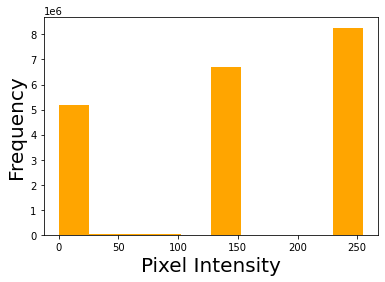

In [8]:
# Histogram of pixel intesity of an image masks.
a = np.asarray(PIL.Image.open(path + '/TCGA-BA-5558-01Z-00-DX1.a134a6eb-86d6-4619-a90b-1d471e8aa348_1_mask.png'))
plt.hist(a[:,:,2].ravel(),color = 'orange')
plt.xlabel('Pixel Intensity',fontsize = 20)
plt.ylabel('Frequency',fontsize = 20)
from collections import Counter
sorted([i for i in Counter(list(a[:,:,0].ravel())).most_common(10)])
a.shape

In [9]:
color_map = {0: ('Background', (0)), # Color encoding for background, tumour and non-tumour regions
             1: ('nontumor', (129)),
             2: ('tumor', (255))}

In [ ]:
################### Extracting patches and saving in HDF5 file format ###################################
storage={} #holder for future pytables

block_shape={} #block shape specifies what we'll be saving into the pytable array, here we assume that masks are 1d and images are 3d
block_shape["img"]= np.array((patch_size_res,patch_size_res,3))
block_shape["mask"]= np.array((patch_size_res,patch_size_res)) 

filters=tables.Filters(complevel=6, complib='zlib') #we can also specify filters, such as compression, to improve storage speed


for phase in phases.keys(): #now for each of the phases, we'll loop through the files
    print(phase)
    
    totals=np.zeros((2,len(classes))) # we can to keep counts of all the classes in for in particular training, since we 
    totals[0,:]=classes               # can later use this information to create better weights

    hdf5_file = tables.open_file(wor_dir + f"./{dataname}_{phase}.pytable", mode='w') #open the respective pytable
    storage["filename"] = hdf5_file.create_earray(hdf5_file.root, 'filename', filenameAtom, (0,)) #create the array for storage
    
    for imgtype in imgtypes: #for each of the image types, in this case mask and image, we need to create the associated earray
        storage[imgtype]= hdf5_file.create_earray(hdf5_file.root, imgtype, img_dtype,  
                                                  shape=np.append([0],block_shape[imgtype]), 
                                                  chunkshape=np.append([1],block_shape[imgtype]),
                                                  filters=filters)
    for filei in phases[phase]: #now for each of the files
        fname=files[filei] 
        
        print(fname)
        for imgtype in imgtypes:
            if(imgtype=="img"): #if we're looking at an img, it must be 3 channel, but cv2 won't load it in the correct channel order, so we need to fix that
                io=cv2.cvtColor(cv2.imread(path+"/"+os.path.basename(fname).replace("_mask.png",".png")),cv2.COLOR_BGR2RGB)
                interp_method=PIL.Image.BICUBIC
                
            else: #if its a mask image, then we only need a single channel (since grayscale 3D images are equal in all channels)
                mask = cv2.imread(fname) 
                x = np.round_(mask[:,:,0]/129,decimals=0, out=None).astype('int') # gives discrete value for masks{0,1,2}
                io = np.stack((x, x, x), axis=-1)
                interp_method=PIL.Image.NEAREST #want to use nearest! otherwise resizing may cause non-existing classes to be produced via interpolation (e.g., ".25")
                
                for i,key in enumerate(classes): #sum the number of pixels, this is done pre-resize, the but proportions don't change which is really what we're after
                    totals[1,i]+=sum(sum(x==key))

            io = np.pad(io, [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size), (0, 0)], mode="reflect") # pad

            # extract small patches out of these big ROIs/HPFs
            io_arr_out = []
            max_cor_x = max(range(0, io.shape[0], patch_size)) # corner coordinates
            max_cor_y = max(range(0, io.shape[1], patch_size))
            for i in range(0, io.shape[0], patch_size):
              for j in range(0, io.shape[1], patch_size):
                patch = io[i:i+patch_size, j:j+patch_size,...]
                patch = cv2.resize(patch, (patch_size_res,patch_size_res), interpolation=interp_method)
                io_arr_out.append(patch)
                if  (i,j) in [(0,0),(0,max_cor_y),(max_cor_x,0),(max_cor_x,max_cor_y)]: # replicating the corner images in the training dataset
                  io_arr_out.append(patch)
           
            
            io_arr_out = np.array(io_arr_out)
            # print(io_arr_out.shape)
          
            #save the 4D tensor to the table
            if(imgtype=="img"):
                storage[imgtype].append(io_arr_out)
            else:  
                storage[imgtype].append(io_arr_out[:,:,:,0].squeeze()) #only need 1 channel for mask data

        storage["filename"].append([fname for x in range(io_arr_out.shape[0])]) #add the filename to the storage array
        
    #lastely, we should store the number of pixels
    npixels=hdf5_file.create_carray(hdf5_file.root, 'numpixels', tables.Atom.from_dtype(totals.dtype), totals.shape)
    npixels[:]=totals
    hdf5_file.close()

In [11]:
def show_im(img): # function to visualize encoded({0,1,2}) masks
  x = np.zeros((img.shape[0], img.shape[1]),dtype = 'int')
  for idx, (label, color) in color_map.items():
    x[img[:,:,0] == idx] = color
  plt.imshow(x)
  plt.show()

In [4]:
from zipfile import ZipFile
!wget https://warwick.ac.uk/study/csde/gsp/eportfolio/directory/pg/saadbashir/code.zip
with ZipFile('code.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

--2022-03-17 05:07:05--  https://warwick.ac.uk/study/csde/gsp/eportfolio/directory/pg/saadbashir/code.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 9581 (9.4K) [application/zip]
Saving to: ‘code.zip’

code.zip            100%[===================>]   9.36K  --.-KB/s    in 0s      

2022-03-17 05:07:06 (226 MB/s) - ‘code.zip’ saved [9581/9581]



# Model development and training

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import tables
import os
import sys
import glob
import PIL
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import model_selection
import sklearn.feature_extraction.image
import random
from unet import UNet #code borrowed from https://github.com/jvanvugt/pytorch-unet
import scipy.ndimage 
import time
import math
import tables
import random
from sklearn.metrics import confusion_matrix
from skimage import io, morphology

import warnings
warnings.filterwarnings("ignore")

seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the cross validation setup
random.seed(seed) # set the seed
print(f"random seed (note down for reproducibility): {seed}")

random seed (note down for reproducibility): 4992696083220547219


Model Parameters

In [6]:
gpuid = 0


# --- unet params
# these parameters get fed directly into the UNET class, and more description of them can be discovered there
n_classes = 3    #number of classes in the data mask that we'll aim to predict
in_channels = 3  #input channel of the data, RGB = 3
padding = True   #should levels be padded
depth = 6      # depth of the network -- default of 5 for unet

wf= 3           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size = 32
patch_size_res = 224
num_epochs = 100 #  run it for 100 if you like
edge_weight = 1 # edges tend to be the most poorly segmented given how little area they 
                  # occupy in the training set, this paramter boosts their values along the lines of the original UNET paper

phases = ["train","val"] # how many phases did we create databases for?
validation_phases= ["val"] # when should we do valiation? note that validation is time consuming, @@@@@@Max: Can add train here as well
                           # so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch

ignore_index = -100

In [7]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    
#specify if we should use a GPU (cuda) or only the CPU
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')
    
print(device)

cpu


Model Initialization

In [8]:
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
model = UNet(n_classes=n_classes, 
             in_channels=in_channels, 
             padding=padding,depth=depth,
             wf=wf, up_mode=up_mode, 
             batch_norm=batch_norm).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	1947915


Dataloader format for model training and validation 

In [12]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None, mask_transform = None, edge_weight= False):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname
        self.edge_weight = False
        
        self.img_transform=img_transform
        self.mask_transform = mask_transform
        
        self.tables=tables.open_file(self.fname)
        self.numpixels=self.tables.root.numpixels[:]
        self.nitems=self.tables.root.img.shape[0]
        self.tables.close()
        
        self.img = None
        self.mask = None
        
    def __getitem__(self, index):
        # opening should be done in __init__ but seems to be
        # an issue with multithreading so doing here
        with tables.open_file(self.fname,'r') as db:
            self.img=db.root.img
            self.mask=db.root.mask
       
            #get the requested image and mask from the pytable
            img = self.img[index,:,:,:]
            mask = self.mask[index,:,:]
        
        mask = mask[:,:,None].repeat(3,axis=2) # in order to use the transformations given by torchvision
        
        img_new = img
        mask_new =mask
        
        seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the transofrmations
        if self.img_transform is not None:
            random.seed(seed) # apply this seed to img transforms
            img_new = self.img_transform(img)

        if self.mask_transform is not None:
            random.seed(seed)
            mask_new = self.mask_transform(mask)
            mask_new = np.asarray(mask_new)[:,:,0].squeeze()

        return img_new,  np.array(mask_new)
    def __len__(self):
        return self.nitems

In [13]:
#note that since we need the transofrmations to be reproducible for both masks and images
#we do the spatial transformations first, and afterwards do any color augmentations
img_transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.ToTensor()
    ])


mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    ])

wor_dir = "/content/drive/MyDrive/Colab Notebooks/cs424/"
dataset={}
dataLoader={}
edge_weight = 1
print(phases)
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    print(phase)
    dataset[phase] = Dataset(wor_dir+f"{dataname}_{phase}.pytable", 
                             img_transform=img_transform, 
                             mask_transform = mask_transform,
                             edge_weight=edge_weight)
    dataLoader[phase] = DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True) 
    
    print(f'{phase} Dataset compelted')

['train', 'val']
train
train Dataset compelted
val
val Dataset compelted


torch.Size([3, 224, 224]) (224, 224)


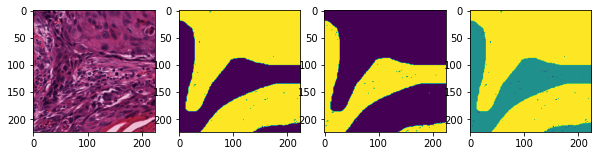

torch.Size([3, 224, 224]) (224, 224)


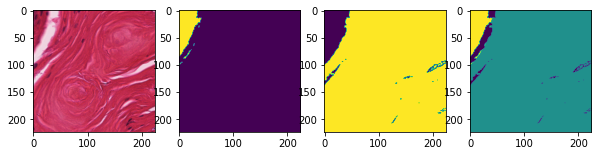

torch.Size([3, 224, 224]) (224, 224)


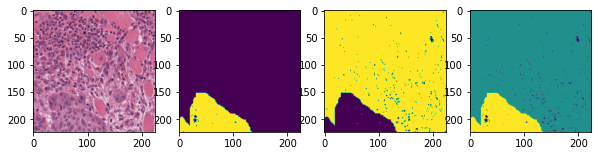

torch.Size([3, 224, 224]) (224, 224)


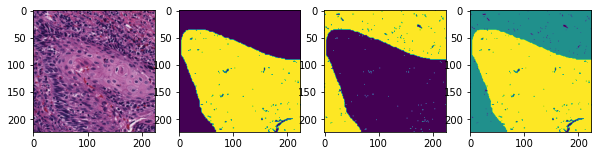

In [19]:
#visualize few example to verify that it is correct
for i in [10,20,37,100]:
  (img,patch_mask)=dataset["train"][i]

  print(img.shape, patch_mask.shape)
  fig, ax = plt.subplots(1,4, figsize=(10,4)) # 1 row, 2 columns

  ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
  ax[1].imshow(patch_mask==2)
  ax[2].imshow(patch_mask==1)
  ax[3].imshow(patch_mask)
  plt.show()

Optimizer and Loss function Initialization

In [20]:
optim = torch.optim.Adam(model.parameters()) # Adam is going to be the most robust

#we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
#to avoid biasing any particular class
nclasses = dataset["train"].numpixels.shape[1]
class_weight = dataset["train"].numpixels[1,:] #don't take ignored class into account here
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) # show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index = ignore_index, reduce=False)
               # reduce = False makes sure we get a 2D output instead of a 1D "summary" value

tensor([0.7052, 0.6790, 0.6158], device='cuda:0')


Training Loop


> **Uncomment below snippet to train the model, else run the next snippet to load the trained model weights to skip the training.**



In [ ]:
# best_loss_on_test = np.Infinity
# edge_weight = torch.tensor(edge_weight).to(device)
# start_time = time.time()
# for epoch in range(num_epochs):
#     #zero out epoch based performance variables 
#     all_acc = {key: 0 for key in phases} 
#     all_loss = {key: torch.zeros(0).to(device) for key in phases}
#     cmatrix = {key: np.zeros((3,3)) for key in phases}

#     for phase in phases: #iterate through both training and validation states

#         if phase == 'train':
#             model.train()  # Set model to training mode
#         else: #when in eval mode, we don't want parameters to be updated
#             model.eval()   # Set model to evaluate mode

#         for ii , (X, y) in enumerate(dataLoader[phase]): #for each of the batches 

            
#             X = X.to(device)  # [Nbatch, 3, H, W]
#             y = y.type('torch.LongTensor').to(device)  # [Nbatch, H, W] with class indices (0, 1)

#             with torch.set_grad_enabled(phase == 'train'): 
#                           # dynamically set gradient computation, in case of validation, this isn't needed
#                           # disabling is good practice and improves inference time
               
#                 prediction = model(X)  # [N, Nclass, H, W]
#                 loss_matrix = criterion(prediction, y)
#                 loss = (loss_matrix).mean()

#                 if phase=="train": #in case we're in train mode, need to do back propogation
#                     optim.zero_grad()
#                     loss.backward()
#                     optim.step()
#                     train_loss = loss


#                 all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

#                 if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
#                     p=prediction[:,:,:,:].detach().cpu().numpy()
#                     cpredflat=np.argmax(p,axis=1).flatten()
#                     yflat=y.cpu().numpy().flatten()

#                     cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat,labels=range(n_classes))

#         all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
#         all_loss[phase] = all_loss[phase].cpu().numpy().mean()


#     print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' \
#               % (timeSince(start_time, (epoch+1) / num_epochs), 
#               epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

#     #if current loss is the best we've seen, save model state with all variables
#     #necessary for recreation
#     if all_loss["val"] < best_loss_on_test:
#         best_loss_on_test = all_loss["val"]
#         print("  **")
#         state = {'epoch': epoch + 1,
#          'model_dict': model.state_dict(),
#          'optim_dict': optim.state_dict(),
#          'best_loss_on_test': all_loss,
#          'n_classes': n_classes,
#          'in_channels': in_channels,
#          'padding': padding,
#          'depth': depth,
#          'wf': wf,
#          'up_mode': up_mode, 'batch_norm': batch_norm}


#         torch.save(state, wor_dir + f"{dataname}_unet_best_model_final.pth") # saves to current working directory
#     else:
#         print("")

Import best model weights attached in the submission file

Update the wor_dir accordingly


In [ ]:
checkpoint = torch.load(wor_dir + f"{dataname}_unet_best_model_final.pth", map_location=torch.device('cpu')) # load best model from current working directory
model.load_state_dict(checkpoint["model_dict"])
model.eval()

Image : Masks
torch.Size([3, 224, 224]) (224, 224)


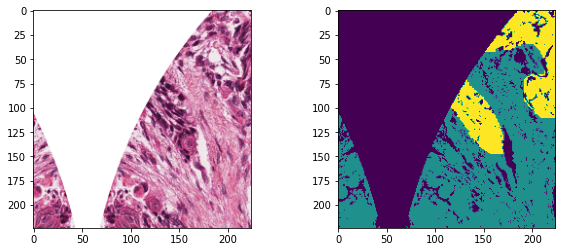

In [24]:
#visualize a single example(image and mask) to verify that it is correct
print("---------Image : Masks---------")
(img,patch_mask)=dataset["val"][36]
print(img.shape, patch_mask.shape)
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
#build output showing original patch  (after augmentation)
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(patch_mask)

--------Prediction Masks  :  True Masks  :  Image---------


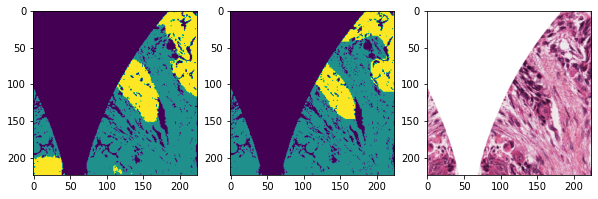

In [26]:
# Showing prediction mask with true mask and image
print("--------Prediction Masks  :  True Masks  :  Image---------")
(img,patch_mask)=dataset["val"][36]
output=model(img[np.newaxis,...].to(device))
output=output.detach().squeeze().cpu().numpy()
output=np.moveaxis(output,0,-1) 
output.shape
fig, ax = plt.subplots(1,3, figsize=(10,4))  # 1 row, 2 columns

ax[0].imshow(np.argmax(output,axis=-1))
ax[1].imshow(patch_mask)
ax[2].imshow(np.moveaxis(img.numpy(),0,-1))

# Test Data Preparation
Update the ORCA test dataset path

In [27]:
test_path = '/content/drive/MyDrive/Colab Notebooks/cs424/test_100'

In [28]:
dataname="assgn3"

patch_size=1000 #size of the tiles to extract and save in the database, must be >= to training size
stride_size=1000 #distance to skip between patches, 1 indicated pixel wise extraction, patch_size would result in non-overlapping tiles
mirror_pad_size=250
resize=1 #resize input images
classes=[0,1,2] #what classes we expect to have in the data, here we have only 2 classes but we could add additional classes and/or specify an index from which we would like to ignore


In [29]:
test_files = [] # extracting test image files
for i in glob.glob(test_path + '/*.png'):
  if i.find('mask') >= 0:
    im = np.asarray(PIL.Image.open(i))
    if im.shape[0] == 4500:
      test_files.append(i)

In [ ]:
imgtypes=["img","mask"]
storage={} #holder for future pytables

block_shape={} #block shape specifies what we'll be saving into the pytable array, here we assume that masks are 1d and images are 3d
block_shape["img"]= np.array((patch_size_res,patch_size_res,3))
block_shape["mask"]= np.array((patch_size_res,patch_size_res)) 

filters=tables.Filters(complevel=6, complib='zlib') #we can also specify filters, such as compression, to improve storage speed


for phase in ['test']: #now for each of the phases, we'll loop through the files
    print(phase)

    hdf5_file = tables.open_file(wor_dir + f"./{dataname}_{phase}.pytable", mode='w') #open the respective pytable
    storage["filename"] = hdf5_file.create_earray(hdf5_file.root, 'filename', filenameAtom, (0,)) #create the array for storage
    
    for imgtype in imgtypes: #for each of the image types, in this case mask and image, we need to create the associated earray
        storage[imgtype]= hdf5_file.create_earray(hdf5_file.root, imgtype, img_dtype,  
                                                  shape=np.append([0],block_shape[imgtype]), 
                                                  chunkshape=np.append([1],block_shape[imgtype]),
                                                  filters=filters)
    for filei in test_files: #now for each of the files
        fname=filei
        
        print(fname)
        for imgtype in imgtypes:
            if(imgtype=="img"): #if we're looking at an img, it must be 3 channel, but cv2 won't load it in the correct channel order, so we need to fix that
                io=cv2.cvtColor(cv2.imread(test_path+"/"+os.path.basename(fname).replace("_mask.png",".png")),cv2.COLOR_BGR2RGB)
                interp_method=PIL.Image.BICUBIC
                
            else: #if its a mask image, then we only need a single channel (since grayscale 3D images are equal in all channels)
                mask = cv2.imread(fname) 
                x = np.round_(mask[:,:,0]/129,decimals=0, out=None).astype('int') #{0,1,2}
                io = np.stack((x, x, x), axis=-1)
                interp_method=PIL.Image.NEAREST #want to use nearest! otherwise resizing may cause non-existing classes to be produced via interpolation (e.g., ".25")
       
            io = np.pad(io, [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size), (0, 0)], mode="reflect")
            # extract small patches out of these big ROIs/HPFs
            io_arr_out = []
            for i in range(0, io.shape[0], patch_size):
              for j in range(0, io.shape[1], patch_size):
                patch = io[i:i+patch_size, j:j+patch_size,...]
                patch = cv2.resize(patch, (patch_size_res,patch_size_res), interpolation=interp_method)
                io_arr_out.append(patch)
           
            
            io_arr_out = np.array(io_arr_out)
            # print(io_arr_out.shape)
          
            #save the 4D tensor to the table
            if(imgtype=="img"):
                storage[imgtype].append(io_arr_out)
            else:  
                storage[imgtype].append(io_arr_out[:,:,:,0].squeeze()) #only need 1 channel for mask data

        storage["filename"].append([fname for x in range(io_arr_out.shape[0])]) #add the filename to the storage array
        
    #lastely, we should store the number of pixels
    totals=np.zeros((2,len(classes))) # we can to keep counts of all the classes in for in particular training, since we 
    totals[0,:]=classes
    npixels=hdf5_file.create_carray(hdf5_file.root, 'numpixels', tables.Atom.from_dtype(totals.dtype), totals.shape)
    npixels[:]=totals
    hdf5_file.close()

In [15]:
# Test Data Loader
dataset_test = Dataset(wor_dir+f"assgn3_test.pytable", 
                             img_transform=img_transform, 
                             mask_transform = mask_transform,
                             edge_weight=edge_weight)
dataLoader_test = DataLoader(dataset_test, batch_size=batch_size, 
                            shuffle=True, num_workers=0, pin_memory=True) 

# Evaluation

In [16]:
# Function to calculate DICE score for a given true and predicted mask
def Dice_Score(true_inds, pred_inds):
    inters = np.sum(true_inds * pred_inds)
    smooth = 0.0001
    return (2. * inters + smooth) / (np.sum(true_inds) + np.sum(pred_inds) + smooth)

def Dice_Multiclass_Score(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
      pred_inds = (y_pred == index)
      true_inds = (y_true == index)
      #print(pred_inds.shape,true_inds.shape)
      dice += Dice_Score(true_inds, pred_inds)
    return dice/numLabels

In [17]:
dice_score = [] # calculate dice score for all the extracted test patches
for img, mask in dataset_test: # , mask_weight 
  output = model(img[np.newaxis,...].to(device))
  output = output.detach().squeeze().cpu().numpy()
  output = np.moveaxis(output,0,-1) 
  y_pred = np.argmax(output,axis=-1).astype('uint8')
  y_true = mask.astype('uint8')
  dice_score.append(Dice_Multiclass_Score(y_true, y_pred,len(classes)))

Median : 0.6658257848981621 Mean : 0.6870149400295662 Standard Deviation : 0.16036651558912282


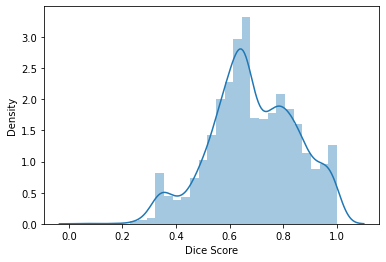

In [18]:
###### Plot the distribution of Test dice score
import seaborn as sns
sns.distplot(dice_score)
plt.xlabel('Dice Score')
plt.ylabel('Density')
print("Median :",np.median(dice_score),"Mean :", np.mean(dice_score),"Standard Deviation :", np.std(dice_score))

Patches with Dice Score >= 0.8


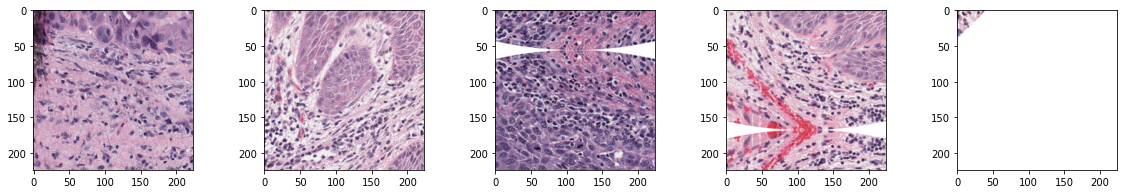

Corresponding Masks


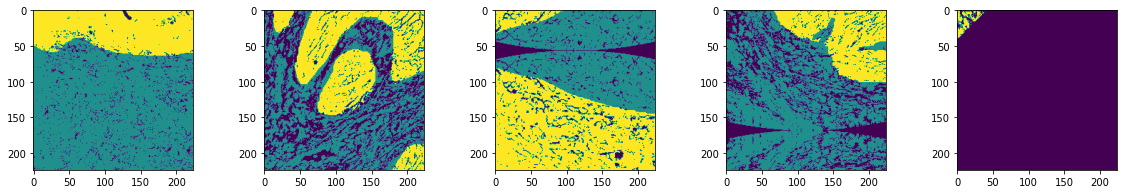

Prediction Masks


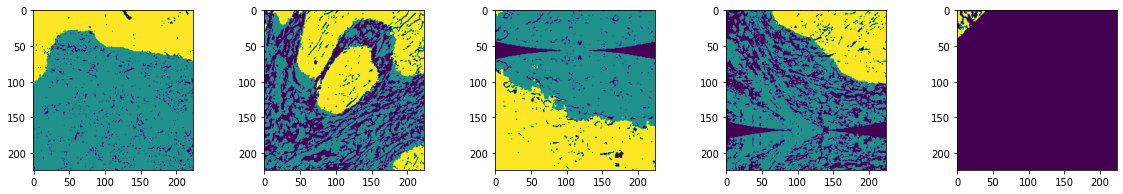

In [22]:
#### Visulization of randomly selected sample test patches along with their true masks and predicted masks######
##### Top percentiles( with dice score >= 0.7) are shown below ######
top_perc = random.sample(list(np.where(np.array(dice_score)>=0.8)[0]),5)
for i in range(3):
  fig = plt.figure(figsize=(20,10))
  if i==0:
    print("Patches with Dice Score >= 0.8")
  elif i == 1:
    print("Corresponding Masks")
  else:
    print("Prediction Masks")
  for j in range(5):
    #img, mask,_ = dataset_test[top_perc[j]]
    img, mask = dataset_test[top_perc[j]]
    output = model(img[np.newaxis,...].to(device))
    output = output.detach().squeeze().cpu().numpy()
    output = np.moveaxis(output,0,-1) 
    y_pred = np.argmax(output,axis=-1)

    plt.subplot(3,5,j+1)
    if i == 0:
      plt.imshow(np.moveaxis(img.numpy(),0,-1))
    elif i ==1:
      plt.imshow(mask)
    else:
      plt.imshow(y_pred)
  plt.show()

Patches with Dice Score <= 0.3


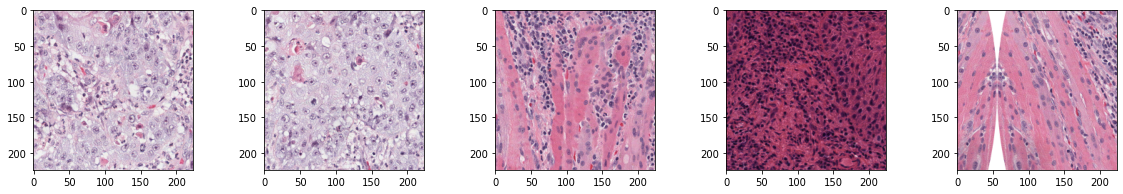

Corresponding Masks


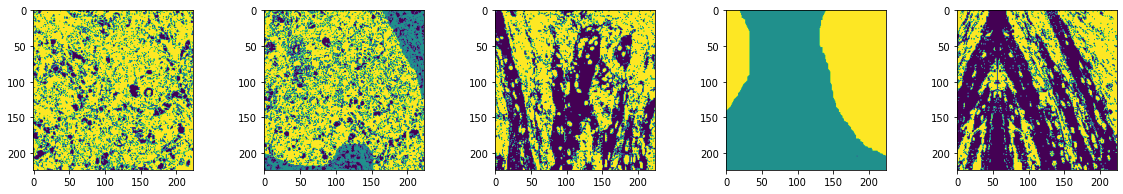

Prediction Masks


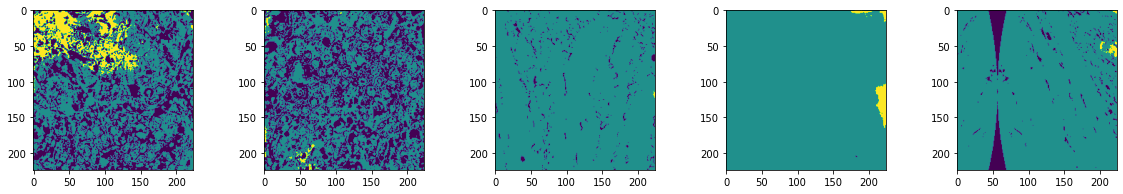

In [48]:
##### Bottom percentiles( with dice score <= 0.7) are shown below ######
bottm_perc = random.sample(list(np.where(np.array(dice_score)<=0.3)[0]),5)
for i in range(3):
  fig = plt.figure(figsize=(20,10))
  if i==0:
    print("Patches with Dice Score <= 0.3")
  elif i == 1:
    print("Corresponding Masks")
  else:
    print("Prediction Masks")
  for j in range(5):
    #img, mask,_ = dataset_test[bottm_perc[j]]
    img, mask = dataset_test[bottm_perc[j]]
    output = model(img[np.newaxis,...].to(device))
    output = output.detach().squeeze().cpu().numpy()
    output = np.moveaxis(output,0,-1) 
    y_pred = np.argmax(output,axis=-1)

    plt.subplot(3,5,j+1)
    if i == 0:
      plt.imshow(np.moveaxis(img.numpy(),0,-1))
    elif i ==1:
      plt.imshow(mask)
    else:
      plt.imshow(y_pred)
  plt.show()

# Task-2

In [ ]:
# install the openslide tools in the OS
!apt-get install openslide-tools

# install the lib for python
!pip install openslide-python

# install the spams rquired for stain separation
! pip install spams 

In [50]:
import openslide as ops
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
import skimage
from skimage import morphology
from skimage import measure
from skimage import io
from skimage.filters.rank import entropy 
from skimage.morphology import disk
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns

 **Update the Path for the WSIs**

In [ ]:
wsi_files = glob.glob("/content/drive/MyDrive/Colab Notebooks/cs424/TCGA-HNSC-HPV/HPV+/*") + glob.glob("/content/drive/MyDrive/Colab Notebooks/cs424/TCGA-HNSC-HPV/HPV-/*")
wsi_files

In [52]:
mag_level_mapping = {20:0,40:1} ### magnification mapping: level-0 is the desired level(with 0.5 mpp) when level 0 has 20X magnification
                                ### level-1 is the desired level(with 0.5 mpp) when level 0 has 40X magnification

### Extracts 512x512 patches with 20X magnfication from the given WSI images
def patch_extracter(path):
  # read the wsi using function OpenSlide #
  wsi_obj = ops.OpenSlide(path)

  reading_level = wsi_obj.level_count-1
  desired_mag = int(wsi_obj.properties['aperio.AppMag']) # extracts magnification of the WSI(20,40)
  desired_level = mag_level_mapping[desired_mag] # leverages above created magnification mapping to get the desired level

  # Binarising the thumbnail of WSIs at maximum level(reading level)
  thumbnail = wsi_obj.get_thumbnail(wsi_obj.level_dimensions[reading_level])
  gray_img = np.array(thumbnail.convert('L'))
  entr_img = entropy(gray_img, disk(5))
  plt.hist(entr_img.ravel())
  plt.show()
  threshold_value = 4 #threshold had-coded based on exploring multiple WSIs thumbnails
  # create the mask from the entrpoy values and threshold on the basis of sleected threshold value
  mask = entr_img
  mask[mask > threshold_value] = 255
  mask[mask <= threshold_value] = 0
  mask = morphology.closing(mask, morphology.disk(3))
  mask = morphology.erosion(mask, morphology.disk(2))
  plt.imshow(mask)
  plt.show()
  x,y = np.where(mask == 255)
  index_pt = random.sample(list(zip(x,y)),200) # randomly selecting 200 pixel coordinates from the reading level

  slide_image_patch = []

  size_ = (512,512)
  i = 0
  
  for id in index_pt:

    lvl_read_dim = wsi_obj.level_dimensions[reading_level] 
    lvl_dsr_dim = wsi_obj.level_dimensions[0]
    # Extrapolating the pixel coordinates in reading level to the level-0, as needed for read_region method.
    y_ = int((id[0]*lvl_dsr_dim[1])/lvl_read_dim[1])
    x_ = int((id[1]*lvl_dsr_dim[0])/lvl_read_dim[0])

    im = np.asarray(wsi_obj.read_region(location = (x_,y_) , level = desired_level, size = size_))
    thres = 150 # threshold estimated by exploring multiple patches and their histograms of pixel intensities
    measure = np.sum(im <= thres)/(im.shape[0]*im.shape[1]) # Criteria to locate pixel coordinates with higher likelihood of high cellularity region
    if measure >= 0.5:
      plt.imshow(im)
      plt.show()
      slide_image_patch.append(im)
    if len(slide_image_patch) < 10:
      continue
    else:
      break

  return slide_image_patch


In [ ]:
wsi_patches = []
for i in wsi_files:
  wsi_patches.append(patch_extracter(i)) # creates list of lists of HPFs for each WSI

Evaluating models performance on extracted HPFs

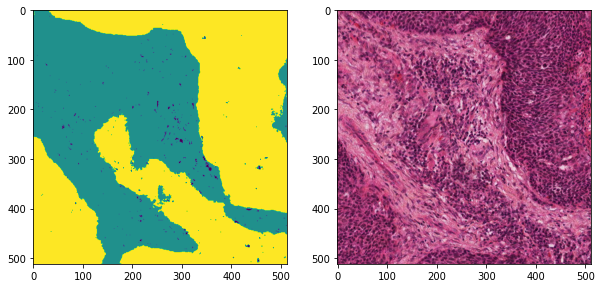

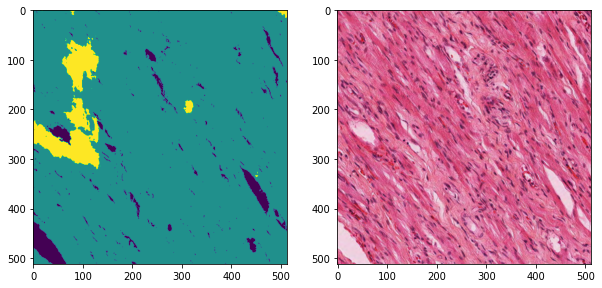

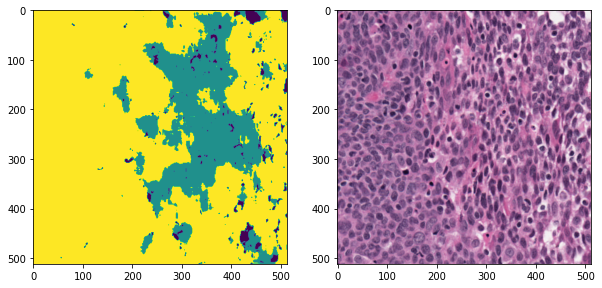

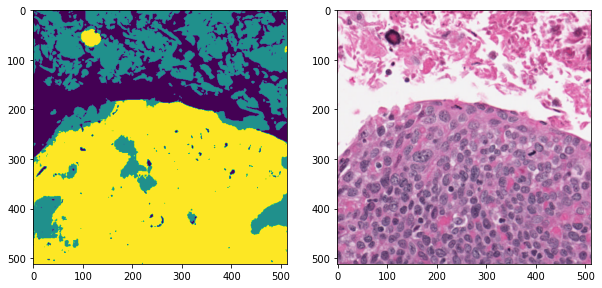

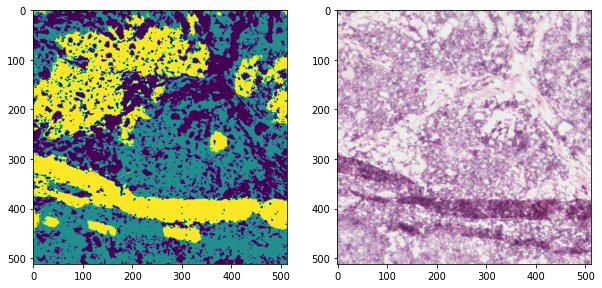

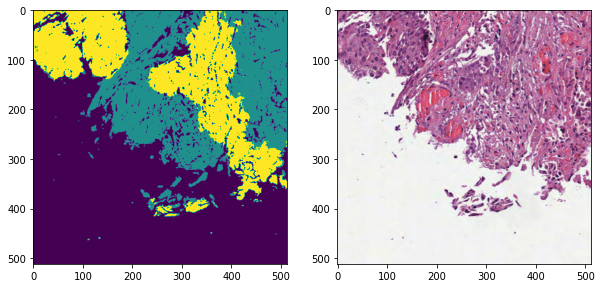

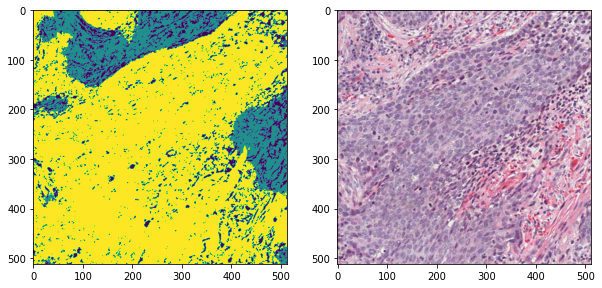

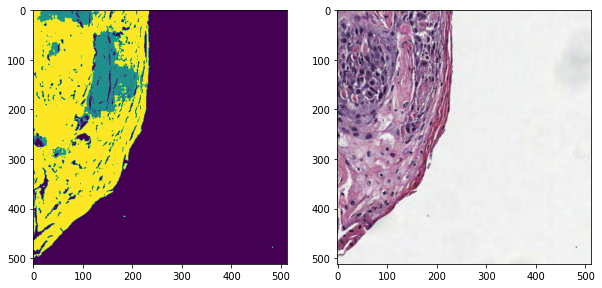

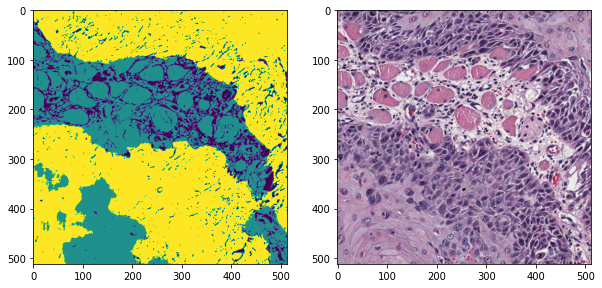

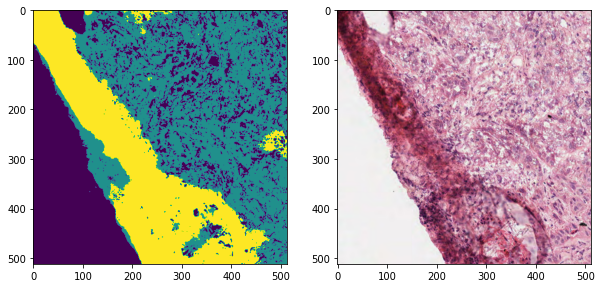

In [55]:
index = random.sample(list(range(100)),10)
wsi_mask = []
for id,im in enumerate(sum(wsi_patches,[])):
  img = img_transform(im[:,:,:3])
  output = model(img[np.newaxis,...].to(device))
  output = output.detach().squeeze().cpu().numpy()
  output = np.moveaxis(output,0,-1) 
  y_pred = np.argmax(output,axis=-1)
  wsi_mask.append(y_pred)
  if id in index: # showing 10 random samples of the patches and their predicted masks
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.imshow(y_pred)
    plt.subplot(1,2,2)
    plt.imshow(im)
    plt.show()

# Task-3
Tissue Statistics calculated at both patch level and WSI level.

Aggregated the calculated stats at patch level to get at WSI level

In [61]:
####### Estimates connected components of tumour/non-tumour regions in a masks by applying morphological tools
def con_comps(bin_im): 
  bin_im = morphology.closing(bin_im, morphology.disk(2))
  bin_im = morphology.erosion(bin_im, morphology.disk(2))
  bin_im = morphology.dilation(bin_im, morphology.disk(2))
  # plt.imshow(bin_im)
  comps = measure.label(bin_im, background=0)
  return len(np.unique(comps))


At patch level

In [62]:
rtna = []
rctn = []
avct = []
pixel_tumr_nontumr = [] # pixels of tumour and non-tumour of each patch to calculate the stats at WSI level
cc_tumr_nontumr = [] # similarly Connected componenets of tumour/non-tumour regions to calculate the stats at WSI level
for i in wsi_mask:
  tumr_bin = (i==2)
  non_tumr_bin = (i==1)

  rtna_ratio = np.sum(tumr_bin)/np.sum(non_tumr_bin) # RTNA for patches
  pixel_tumr_nontumr.append((np.sum(tumr_bin),np.sum(non_tumr_bin))) 
  rtna.append(rtna_ratio)

  rctn_ratio = con_comps(tumr_bin)/con_comps(non_tumr_bin) # RCTN for patches
  cc_tumr_nontumr.append((con_comps(tumr_bin),con_comps(non_tumr_bin)))
  rctn.append(rctn_ratio)

  avct.append(con_comps(tumr_bin)) # at patch level it is just the count of connected components of the tumour regions

In [63]:
feature_df = pd.DataFrame({"rtna":rtna,"rctn":rctn,"avct":avct})

Text(0.5, 1.0, 'Patch level correlation')

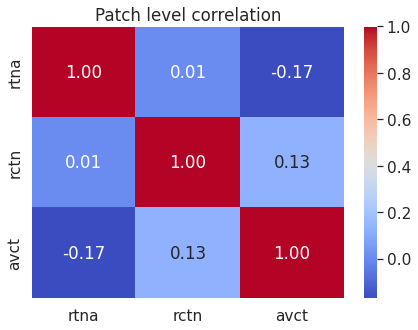

In [64]:
sns.set(font_scale = 1.4)
fig, ax = plt.subplots(figsize=(7, 5))
nrmlzd_df = (feature_df-feature_df.min())/(feature_df.max()-feature_df.min())# Normalizing the metrices to show the correslation matrix
sns.heatmap(nrmlzd_df.corr(),annot = True,cmap='coolwarm',fmt='.2f')
plt.title('Patch level correlation')

At WSI level

In [65]:
rtna_wsi = []
rctn_wsi = []
avct_wsi = []
k = 0
for i in wsi_patches: # iteratively calculating the metrices at WSI level by aggregating the patch level features

  corsdng_rtna = pixel_tumr_nontumr[k:k+len(i)]
  corsdng_rctn = cc_tumr_nontumr[k:k+len(i)]
  corsdng_avct = avct[k:k+len(i)]

  

  rtna_wsi.append(sum([j[0] for j in corsdng_rtna])/sum([j[1] for j in corsdng_rtna]))
  rctn_wsi.append(sum([j[0] for j in corsdng_rctn])/sum([j[1] for j in corsdng_rctn]))
  avct_wsi.append(np.mean(corsdng_avct))
  k = k + len(i)


In [66]:
feature_df_wsi = pd.DataFrame({"rtna":rtna_wsi,"rctn":rctn_wsi,"avct":avct_wsi})

Text(0.5, 1.0, 'WSI level correlation')

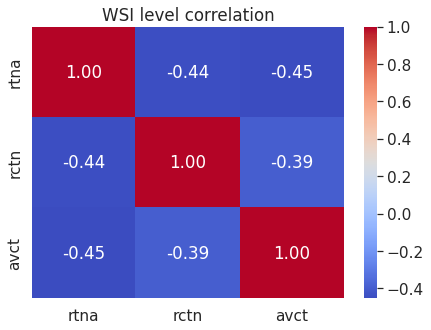

In [67]:
sns.set(font_scale = 1.4)
fig, ax = plt.subplots(figsize=(7, 5))
nrmlzd_df_wsi = (feature_df_wsi-feature_df_wsi.min())/(feature_df_wsi.max()-feature_df_wsi.min())
sns.heatmap(nrmlzd_df_wsi.corr(),annot = True,cmap='coolwarm',fmt='.2f')
plt.title('WSI level correlation')

Scatter plot

Below snippet is to be used to plot interactive 3D plots, comment them in case running not on colab

The green dots represents HPV+ and the red represents the HPV-

In [108]:
!pip uninstall ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget  

Text(0.5, 0, 'AVCT   ')

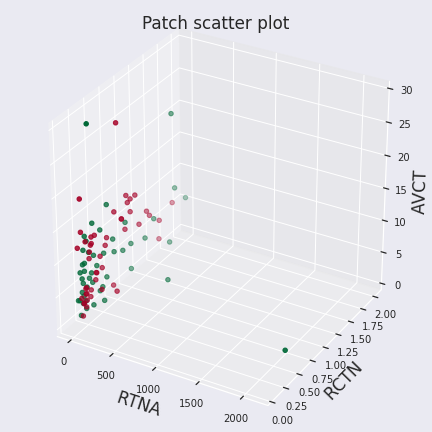

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


In [72]:
# creating figure
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 2})
fig = plt.figure(figsize = (6,6))
ax = Axes3D(fig)

plot = ax.scatter(rtna, rctn, avct, c = sorted([i%2 for i in range(len(wsi_mask))])[::-1], cmap='RdYlGn')
ax.tick_params(axis='both', which='major', labelsize=10)
# setting title and labels
ax.set_title("Patch scatter plot")
ax.set_xlabel('RTNA   ')
ax.set_ylabel('RCTN   ')
ax.set_zlabel('AVCT   ')

Text(0.5, 0, 'AVCT WSI')

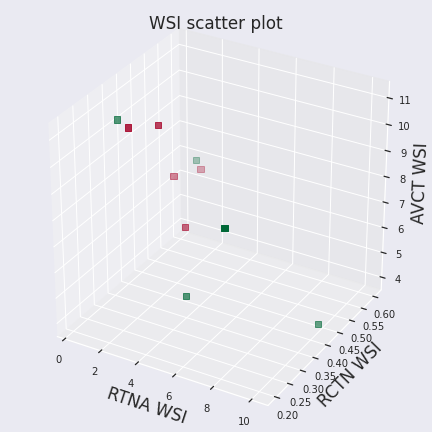

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


In [73]:
# creating figure
fig = plt.figure(figsize = (6,6))
ax = Axes3D(fig)
hpv_map = [1,1,1,1,1,0,0,0,0,0]
plot = ax.scatter(rtna_wsi, rctn_wsi, avct_wsi, marker="s", c=hpv_map, s=40, cmap="RdYlGn")
ax.tick_params(axis='both', which='major', labelsize=10)
# setting title and labels
ax.set_title("WSI scatter plot")
ax.set_xlabel('RTNA WSI')
ax.set_ylabel('RCTN WSI')
ax.set_zlabel('AVCT WSI')